# CLUSTERING ON ONLINE REATAIL II DATTASET   

# SOURCE :- https://archive.ics.uci.edu/dataset/502/online+retail+ii

# LOADING DATASET

In [ ]:
!wget "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"      #downloading the data

--2023-07-22 13:38:36--  https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘online+retail+ii.zip’

online+retail+ii.zi     [   <=>              ]  43.51M  94.1MB/s    in 0.5s    

2023-07-22 13:38:36 (94.1 MB/s) - ‘online+retail+ii.zip’ saved [45622418]



In [ ]:
!unzip "online+retail+ii.zip"                                                   #extracting data

Archive:  online+retail+ii.zip
 extracting: online_retail_II.xlsx   


# DATA ANALYSIS

In [ ]:
# import required libraries for dataframe and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
pd.set_option("display.max_columns",None)
pd.set_option("display.width",1000)

In [ ]:
datasets:list=list()                                                            # to store all sheet as pandas.DataFrame
for sheet in pd.ExcelFile('online_retail_II.xlsx').sheet_names:                 # get all sheet by sheet names from file
  datasets.append(pd.read_excel('online_retail_II.xlsx',sheet_name=sheet))      # read each sheet as pandas.DataFrame and append to datasets list

In [ ]:
if len(datasets)>1:dataset=pd.concat(datasets,ignore_index=True)                # if multiple sheets found (i.e. multiple data-frame) in list then only concatinate all dataframes
else:dataset=datasets[0]                                                        # if only one is sheet found, then no need for concatination
del datasets                                                                    # remove datasets list (not needed)
dataset.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
dataset.shape                                                                   #checking dataset shape

(1067371, 8)

In [ ]:
dataset.info()                                                                  #check dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [ ]:
dataset.describe()                                                              #dataframe description

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


# DATA PREPROCESSING

In [ ]:
# Calculating the Missing Values % contribution in DF
df_null = round(100*(dataset.isnull().sum())/len(dataset), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [ ]:
# Droping rows having missing values
retail = dataset.dropna()
retail.shape

(824364, 8)

In [ ]:
# Changing the datatype of Customer Id
dataset['Customer ID'] = dataset['Customer ID'].astype(str)

#Preparation Of Data

In [ ]:
#new attribute : Monetary
dataset['Amount'] = dataset['Quantity']*dataset['Price']
rfm_m = dataset.groupby('Customer ID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,Customer ID,Amount
0,12346.0,-64.68
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4404.54
4,12350.0,334.40


In [ ]:
#new attribute : Frequency
rfm_f = dataset.groupby('Customer ID')['Invoice'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head()

,Customer ID,Frequency
0,12346.0,48
1,12347.0,253
2,12348.0,51
3,12349.0,180
4,12350.0,17


In [ ]:
#merging the two dataframes
rfm = pd.merge(rfm_m, rfm_f, on='Customer ID', how='inner')
rfm.head()

,Customer ID,Amount,Frequency
0,12346.0,-64.68,48
1,12347.0,5633.32,253
2,12348.0,2019.40,51
3,12349.0,4404.54,180
4,12350.0,334.40,17


In [ ]:
#new attribute : Recency
#convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'],format='%d-%m-%Y %H:%M')

<ipython-input-25-e02a8d24cf33>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'],format='%d-%m-%Y %H:%M')


In [ ]:
#compute the maximum date to know the last transaction date
max_date = max(dataset['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
#compute the difference between max date and transaction date
dataset['Diff'] = max_date - dataset['InvoiceDate']
dataset.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,Diff
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,738 days 05:05:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,738 days 05:05:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,738 days 05:05:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,738 days 05:05:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,738 days 05:05:00


In [ ]:
#compute last transaction date to get the recency of customers
rfm_p = dataset.groupby('Customer ID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,Customer ID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
#extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,Customer ID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
#merge tha dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p, on='Customer ID', how='inner')
rfm.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,Customer ID,Amount,Frequency,Recency
0,12346.0,-64.68,48,325
1,12347.0,5633.32,253,1
2,12348.0,2019.40,51,74
3,12349.0,4404.54,180,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

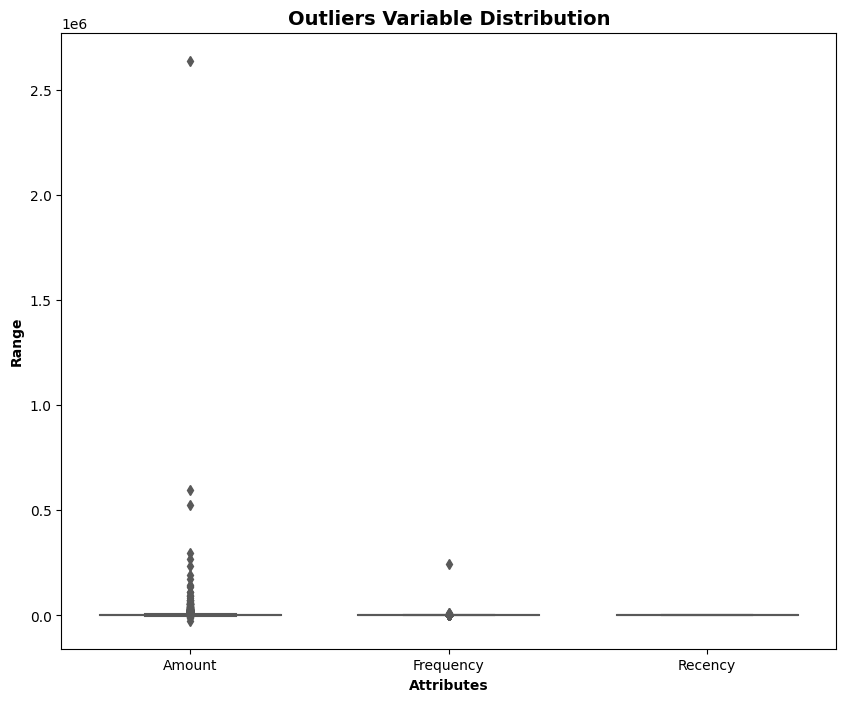

In [ ]:
#outlier Analysis of Amount Frequency and Recency
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

#Rescaling The Attributes

In [ ]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(5831, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.668571,-0.407287,0.565006
1,1.346911,0.887540,-0.962200
2,0.068605,-0.388338,-0.618107
3,0.912270,0.426455,-0.882069
4,-0.527409,-0.603090,0.489589


#K-Means Clustering

In [ ]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [ ]:
kmeans.labels_

array([1, 0, 2, ..., 1, 1, 0], dtype=int32)

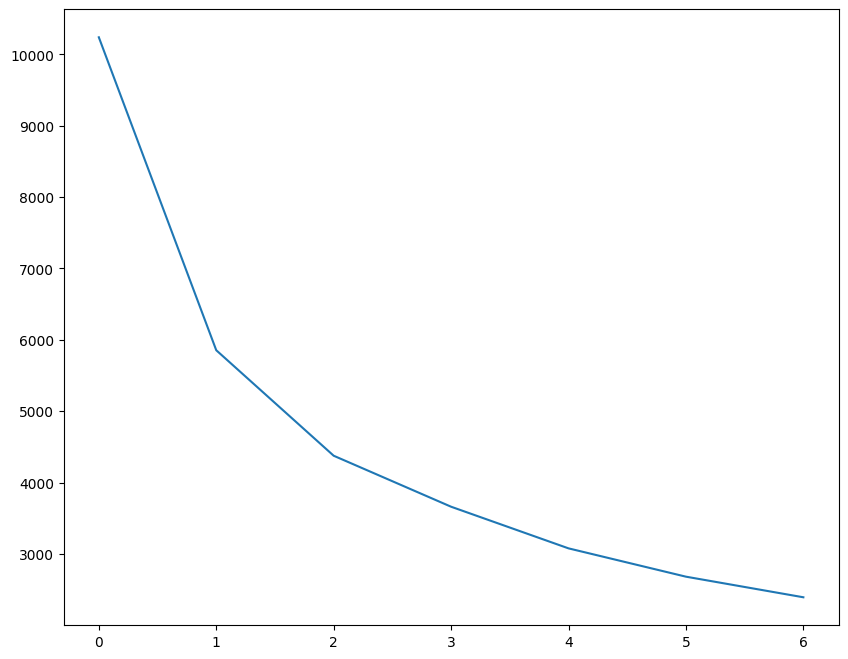

In [ ]:
#elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

#plot the SSDs for each n_clusters
plt.plot(ssd)

#Silhouette Analysis

In [ ]:
#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    #intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,  n_init=10)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    #silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5485308609163347
For n_clusters=3, the silhouette score is 0.5004991432009669
For n_clusters=4, the silhouette score is 0.4957107935941256
For n_clusters=5, the silhouette score is 0.490727878423961
For n_clusters=6, the silhouette score is 0.4462478973273721
For n_clusters=7, the silhouette score is 0.4289573238211565
For n_clusters=8, the silhouette score is 0.41595674142558897


In [ ]:
#final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [ ]:
kmeans.labels_

array([0, 2, 1, ..., 0, 0, 1], dtype=int32)

In [ ]:
#assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Customer ID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,-64.68,48,325,0
1,12347.0,5633.32,253,1,2
2,12348.0,2019.40,51,74,1
3,12349.0,4404.54,180,18,1
4,12350.0,334.40,17,309,0


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

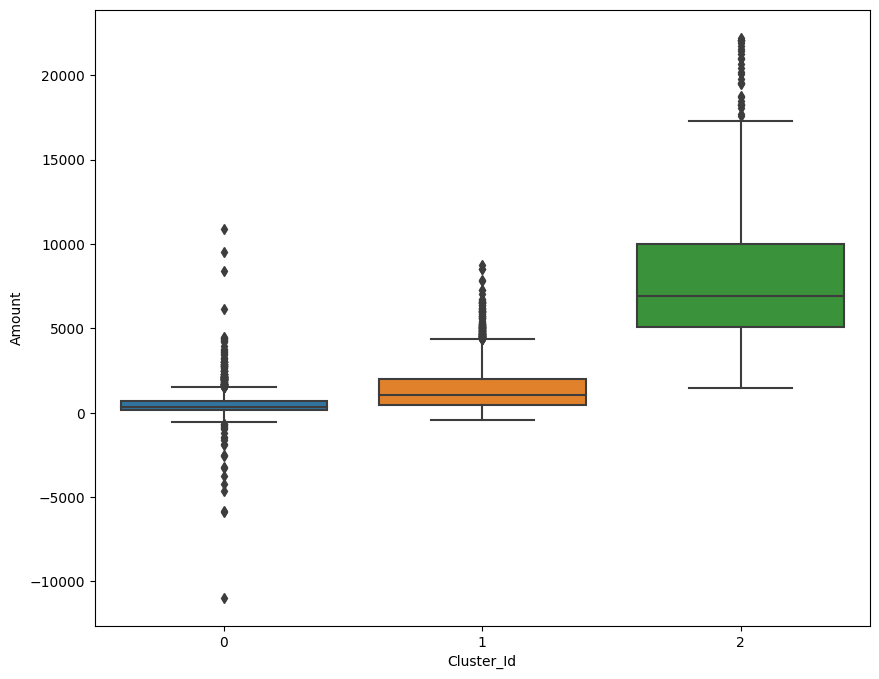

In [ ]:
#box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

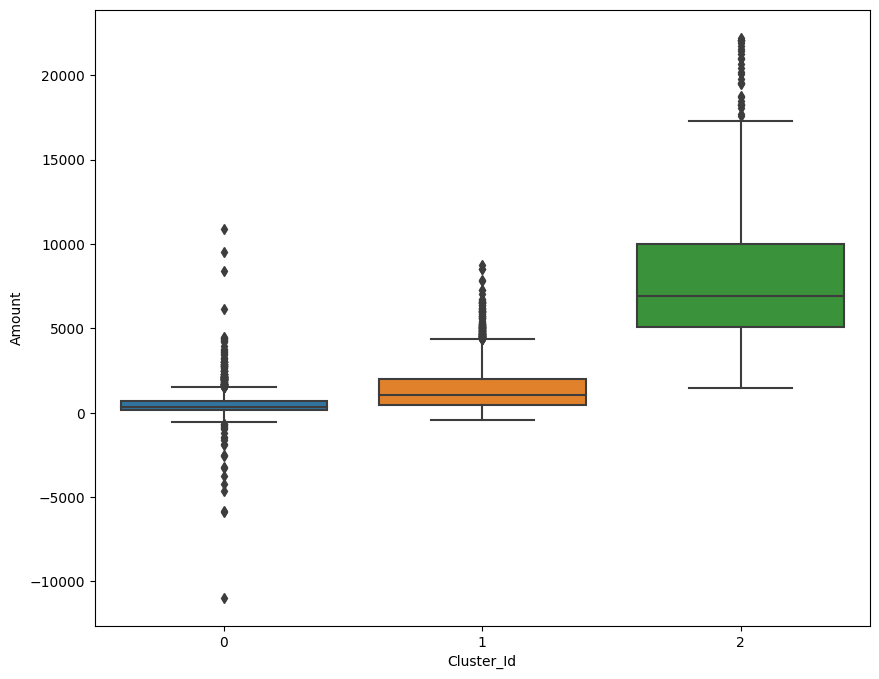

In [ ]:
#box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

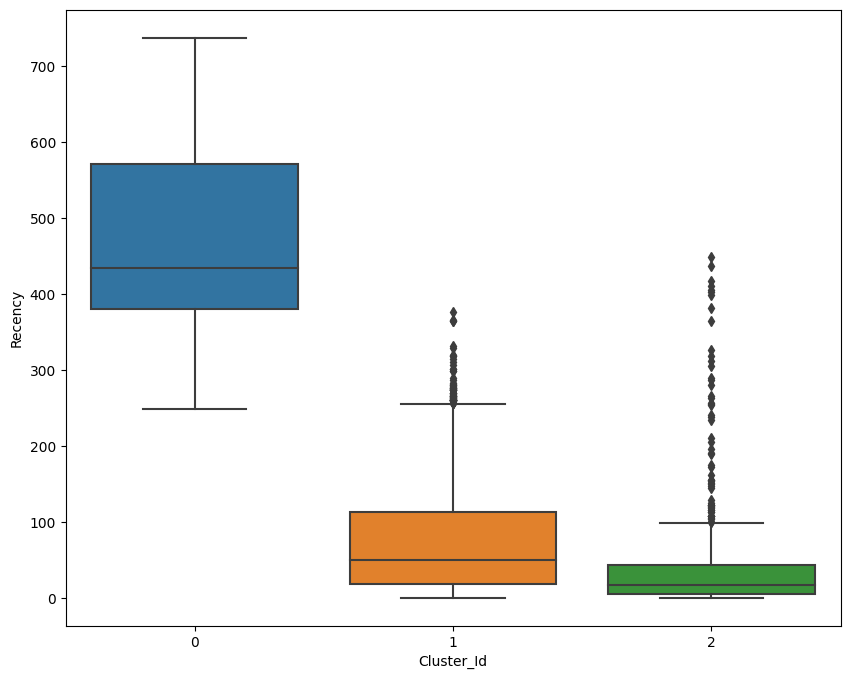

In [ ]:
#box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)